# Small-scale analysis of the tracklet data: does direct alignment-based pose refinement work?

Spoiler alert: No.

Takeaway: Improving the sparse methods is the way forward for the time being; track more features across more frames, and do more joint car trajectory optimization.

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [150]:
%matplotlib inline

In [151]:
from matplotlib import rc
# Enable full LaTeX support in plot text. Requires a full-fledged LaTeX installation
# on your system, accessible via PATH.
# rc('text', usetex=True)

plt.rcParams["figure.figsize"] = (16, 6)

In [63]:
%%bash
ls -t ../csv/aug-21-tracklet-results/*-3d-tracking-result.csv | head -n5

../csv/aug-21-tracklet-results/kitti-tracking-sequence-0001-tracking-dataset-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-NO-fusion-weights-3d-tracking-result.csv
../csv/aug-21-tracklet-results/kitti-tracking-sequence-0001-tracking-dataset-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-with-direct-ref-NO-fusion-weights-3d-tracking-result.csv
../csv/aug-21-tracklet-results/kitti-tracking-sequence-0006-tracking-dataset-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-NO-fusion-weights-3d-tracking-result.csv
../csv/aug-21-tracklet-results/kitti-tracking-sequence-0006-tracking-dataset-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-with-direct-ref-NO-fusion-weights-3d-tracking-result.csv
../csv/aug-21-tracklet-results/kitti-tracking-sequence-0003-tracking-dataset-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-dep

## What to visualize

 * Accuracy over time, aggregated over multiple vehicle tracks, say, more than 3-5 frames in length
 * Simple bar chart showin trans/rot errors for no-da/da, possibly also labeled with the exact numbers.

## Initial tests

In [56]:
CSV_FILE_DN_NO_DIRECT = "../cmake-build-debug/kitti-tracking-sequence-0006-tracking-dataset-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-NO-direct-ref-3d-tracking-result.csv"
CSV_FILE_DN_WITH_DIRECT = "../cmake-build-debug/kitti-tracking-sequence-0006-tracking-dataset-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-with-direct-ref-3d-tracking-result-no-param-tweaks.csv"
CSV_FILE_DN_WITH_DIRECT_TWEAKED = "../cmake-build-debug/kitti-tracking-sequence-0006-tracking-dataset-offset-0-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-with-direct-ref-3d-tracking-result-<todo>.csv"

In [58]:
dn_no_direct_frame = pd.read_csv(CSV_FILE_DN_NO_DIRECT)
dn_direct_frame = pd.read_csv(CSV_FILE_DN_WITH_DIRECT)
print(len(dn_no_direct_frame), len(dn_direct_frame))
# dn_no_direct_frame

56 56


In [59]:
dn_no_direct_frame.head()

,frame_id,track_id,trans_error,rot_error
0,43,2,0.137243,0.022683
1,44,2,0.084931,0.008583
2,45,2,0.071146,0.014435
3,46,2,0.059743,0.009506
4,47,2,0.013864,0.001544


In [60]:
dn_direct_frame.head()

,frame_id,track_id,trans_error,rot_error
0,43,2,0.137243,0.022683
1,44,2,0.290606,0.036613
2,45,2,0.276341,0.031502
3,46,2,0.260395,0.029782
4,47,2,0.174290,0.014278


In [61]:
# dn_no_direct_frame[dn_no_direct_frame['frame_id'] == 43]
# dn_no_direct_frame[dn_no_direct_frame['track_id'] == 2]

# dn_no_direct_frame['track_id']


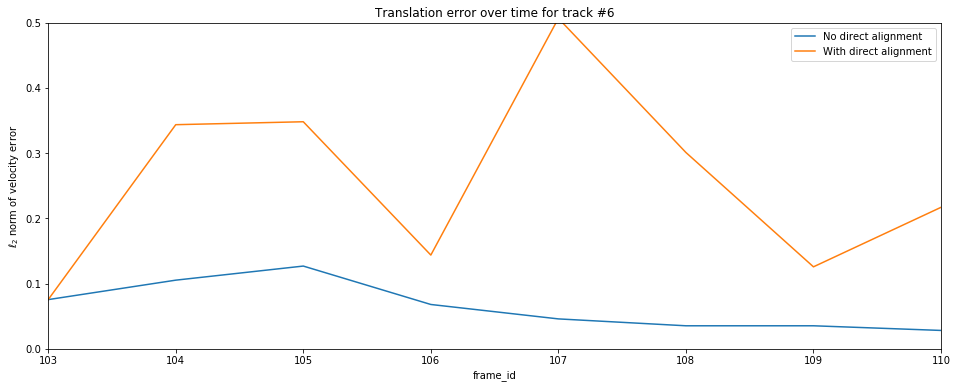

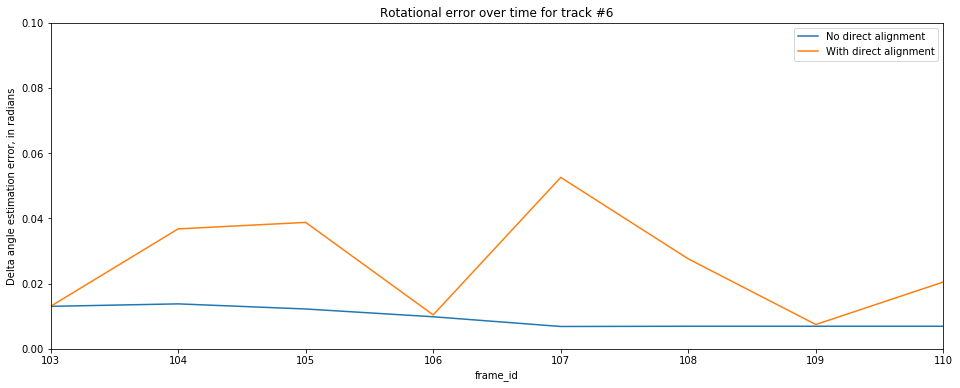

In [62]:
def compare_tracks(no_direct_frame, direct_frame, track_id=6):
    nd_track = no_direct_frame[no_direct_frame.track_id == track_id]
    d_track = direct_frame[direct_frame.track_id == track_id]
    result = pd.DataFrame({
        'frame_id': nd_track.frame_id,
        'trans_error_no_direct': nd_track.trans_error,
        'rot_error_no_direct': nd_track.rot_error,
        'trans_error_with_direct': d_track.trans_error,
        'rot_error_with_direct': d_track.rot_error
    })
    ax = result.plot('frame_id', ['trans_error_no_direct', 'trans_error_with_direct'])
    ax.set_ylim([0, 0.5])
    ax.set_ylabel(r"$\ell_2$ norm of velocity error")
    ax.set_title("Translation error over time for track #{}".format(track_id))
    ax.legend(["No direct alignment", "With direct alignment"])
    
    ax = result.plot('frame_id', ['rot_error_no_direct', 'rot_error_with_direct'])
    ax.set_ylim([0, 0.1])
    ax.set_ylabel("Delta angle estimation error, in radians")
    ax.set_title("Rotational error over time for track #{}".format(track_id))
    ax.legend(["No direct alignment", "With direct alignment"])

compare_tracks(dn_no_direct_frame, dn_direct_frame)

## Aggregating multiple tracks' information, over multiple sequences.

Aggregated data from 33 tracks.


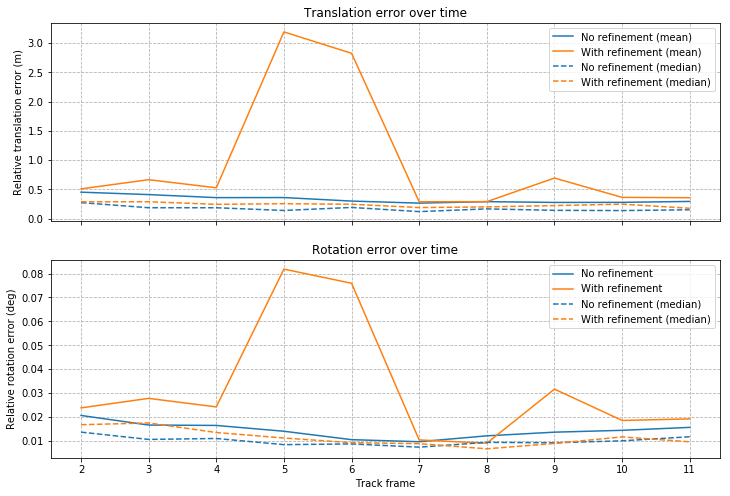

In [225]:
import os

def no_extreme_error(track):
    for row in track.index:
        if track['trans_error'][row] > 12.5:
            print("Too extreme!")
            return False
    
    return True


def get_tracks(df, prefix, min_track_len):
    """Returns an id->[entry] map from the given tracklet evaluation data."""
    gb = df.groupby('track_id')
    tracks = {}
    for track_id in gb.groups.keys():
        track = df[df['track_id'] == track_id]
        
        if len(track) >= min_track_len: # and no_extreme_error(track):
            track_key = '{}-{}'.format(prefix, track_id)
            track_start = track.index[0]
            new_index = track.index - track_start
            track = track.set_index(new_index)
#             print(track.index)
            tracks[track_key] = track
            
    return tracks         
    

def analyze_tracklets(root_dir, **kw):
    csv_pattern = 'kitti-tracking-sequence-{seq_id:04d}-tracking-dataset-offset-0-' \
        'depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-' \
        'dynamic-mode-{direct_ref_type}-direct-ref-NO-fusion-weights-3d-tracking-result.csv'
        
    min_track_len = kw.get('min_track_len', 10)
    seq_ids = np.arange(7)
    direct_ref_types = ['NO', 'with']
    
    data_raw = {}
    for ref_type in direct_ref_types:
        data_raw[ref_type] = {
            'track_id': []
        }
        data_raw[ref_type]['rot'] = {}
        data_raw[ref_type]['trans'] = {}
        for i in range(min_track_len):
            data_raw[ref_type]['rot']['frame-{:02d}'.format(i)] = []
            data_raw[ref_type]['trans']['frame-{:02d}'.format(i)] = []
        
    
    for direct_ref_type in direct_ref_types:
        for seq_id in seq_ids:
            csv_fname = csv_pattern.format(seq_id=seq_id, direct_ref_type=direct_ref_type)
            csv_fpath = os.path.join(root_dir, csv_fname)
            
            df = pd.read_csv(csv_fpath)
            prefix = '{}-{}'.format(seq_id, direct_ref_type)
            tracks = get_tracks(df, prefix, min_track_len)
            
            for track_key, track in tracks.items():
                data_raw[direct_ref_type]['track_id'].append(track_key)
                for i, frame_idx in enumerate(track.index[:min_track_len]):
                    data_raw[direct_ref_type]['rot']['frame-{:02d}'.format(i)].append(track['rot_error'][frame_idx])
                    data_raw[direct_ref_type]['trans']['frame-{:02d}'.format(i)].append(track['trans_error'][frame_idx])
        
#     print(np.array(data_raw).shape)
    no_da_rot = pd.DataFrame(data_raw['NO']['rot'])
    with_da_rot = pd.DataFrame(data_raw['with']['rot'])
    no_da_trans = pd.DataFrame(data_raw['NO']['trans'])
    with_da_trans = pd.DataFrame(data_raw['with']['trans'])
    
    fig, (ax_trans, ax_rot) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
    x = np.arange(2, min_track_len+2)
    MPL_BLUE = 'C0'
    MPL_ORANGE = 'C1'
    
#     ax_trans.errorbar(x, no_da_trans.mean(), yerr=no_da_trans.std(), label='No refinement (mean)')
#     ax_trans.errorbar(x, with_da_trans.mean(), yerr=with_da_trans.std(), label='With refinement (mean)')
    ax_trans.plot(x, no_da_trans.mean(), label="No refinement (mean)")
    ax_trans.plot(x, with_da_trans.mean(), label="With refinement (mean)")
    ax_trans.plot(x, no_da_trans.median(), '--', color=MPL_BLUE, label="No refinement (median)")
    ax_trans.plot(x, with_da_trans.median(), '--', color=MPL_ORANGE, label="With refinement (median)")
    
    ax_trans.set_ylabel("Relative translation error (m)")
    ax_trans.legend()
    ax_trans.grid(color='0.7', linestyle='--')   
    ax_trans.set_title("Translation error over time")
    
    ax_rot.plot(x, no_da_rot.mean(), label="No refinement")
    ax_rot.plot(x, with_da_rot.mean(), label="With refinement")
    ax_rot.plot(x, no_da_rot.median(), '--', color=MPL_BLUE, label="No refinement (median)")
    ax_rot.plot(x, with_da_rot.median(), '--', color=MPL_ORANGE, label="With refinement (median)")
    ax_rot.legend()    
    ax_rot.grid(color='0.7', linestyle='--')   

    ax_rot.set_title("Rotation error over time")
    
    ax_rot.set_ylabel("Relative rotation error (deg)")
    ax_rot.set_xlabel("Track frame")
    ax_rot.set_xticks(np.arange(2, 2+min_track_len))
    
    assert(len(no_da_trans) == len(with_da_trans) and len(no_da_trans) == len(no_da_rot) and len(no_da_trans) == len(with_da_rot))
    print("Aggregated data from {} tracks.".format(len(no_da_trans)))
    
    fig_root = os.path.join('..', 'fig')
    fig.savefig(os.path.join(fig_root, 'tracklet-results-agg.eps'))
    
    
analyze_tracklets(os.path.join('..', 'csv', 'aug-21-tracklet-results'))